# HW1-GMM

SA22011090 余致远

高斯混合模型与 EM 算法

数据集：Iris 数据集

数据描述：https://www.kaggle.com/datasets/uciml/iris，可通过 sklearn 直接导入数据集

任务描述：使用高斯混合模型与 EM 算法对数据进行分类计算，mixture components 设置为3。

要求输出：不同高斯分布的 mean 和 variance，每个高斯分布对应的权重，plot 出分布的图。

EM 算法可以参考
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html。

Optional：尝试不同的 covariance structures，包括 spherical、diagonal、tied 与 full。

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
features = iris.data
labels = iris.target

gmm = GaussianMixture(n_components=3, covariance_type='full')
# iris['feature_names']
iris.data.shape

(150, 4)

$\ell(\theta) = \sum_{i=1}^n \log \left( \sum_{k=1}^2 \pi_k \underbrace{N(x_i;\mu_k, \sigma_k^2)}_{L[i,k]} \right )$

In [52]:
from scipy.stats import multivariate_normal

class myGaussianMixture(object):
    # mostly borrowed from https://xavierbourretsicotte.github.io/gaussian_mixture.html

    def __init__(self, n_components = 3, max_iter = 100, tol = 0.001):

        # Parameters
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

        # Attributes
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

        self.log_likelihoods = []

    def fit(self, X= None):

        n,d = X.shape           # [150, 4]
        k = self.n_components   # 3 types

        # initialize means
        mu = X[np.random.choice(n,k,replace = False)]   # [points=150, types=3]

        # initialize a covariance matrix for each gaussian, uppercase for mat
        Sigma = [np.eye(d)] * k                         # k=3 types * [eye(features=4)]

        # initialize the probability for each gaussian pi
        pi = np.array([1 / k] * k)                      # when summing up, count \sum pi*P

        # initialize responsibility matrix: n points for each gaussian
        W = np.zeros((n,k))                             # [points=150, types=3]

        # initialize list of log-likelihoods
        log_likelihoods = []
        
        iter = 0
        while iter < self.max_iter:

            # E-step

            # lambda function for gaussian pdf
            P = lambda m, s: multivariate_normal.pdf(X, mean = m, cov = s, allow_singular=True)
            
            # nominator of responsibilities: j is the j-th gaussian
            # for each node, count the expectation of belonging to type j
            for j in range(k):
                W[:, j] = pi[j] * P(mu[j], Sigma[j])

            # log likelihood computation (same as nominator of responsibilities)    
            l = np.sum(np.log(np.sum(W, axis = 1)))

            # store log likelihood in list
            log_likelihoods.append(l)

            # compute W matrix by dividing by denominator (the sum along j) 
            W = (W.T / W.sum(axis = 1)).T

            # sum of w^i entries along j (used for parameter updates)
            # these are the soft weighted number of datapoints belonging to each gaussian
            W_sum = np.sum(W, axis = 0)


            # M step

            for j in range(k):

                ## Update means
                mu[j] = (1. / W_sum[j]) * np.sum(W[:, j] * X.T, axis = 1).T 

                ## Update covariances
                Sigma[j] = ((W[:,j] * ((X - mu[j]).T)) @ (X - mu[j])) / W_sum[j]

                ## Update probabilities of each gaussian
                pi[j] = W_sum[j] / n

            # check for convergence
            if len(log_likelihoods) < 2: continue
            if np.abs(l - log_likelihoods[-2]) < self.tol: break

        self.means_ = mu
        self.covariances_ = Sigma
        self.weights_ = pi
        self.log_likelihoods = log_likelihoods
    
    def predict(self, X):
        probs = np.array([ multivariate_normal.pdf(X, mean = self.means_[j], cov = self.covariances_[j]) for j in range(self.n_components) ])
        return np.argmax(probs, axis = 0)

In [59]:
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from matplotlib import patches

X = iris.data
gmm = myGaussianMixture()
gmm.fit(X)
y = gmm.predict(X)
print(y)

print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


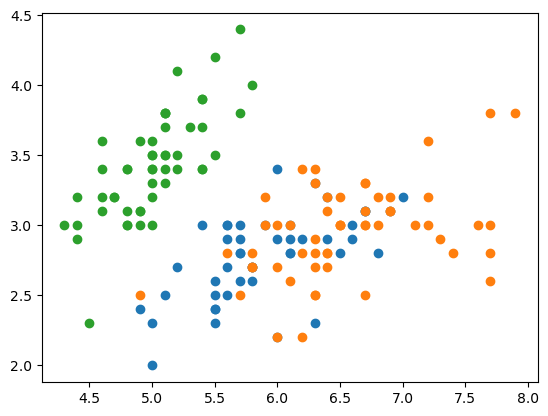

In [61]:
type = {'0':[],'1':[],'2':[]}
for i in range(len(X)):
    # print(i, str(y[i]))
    type[str(y[i])].append(i)
# type

iris_result = [X[type['0']],X[type['1']],X[type['2']]]
# iris_result

# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
for i in range(len(iris_result)):
    # iris_result[i] = pca.fit_transform(iris_result[i])
    plt.scatter(iris_result[i][:,0],iris_result[i][:,1])

In [62]:
gmm.means_

array([[5.91513787, 2.77785927, 4.20189782, 1.29710082],
       [6.54476071, 2.94874317, 5.47998145, 1.98487718],
       [5.006     , 3.428     , 1.462     , 0.246     ]])

In [63]:
gmm.covariances_

[array([[0.2753255 , 0.09690444, 0.18471488, 0.05441802],
        [0.09690444, 0.09263655, 0.09112867, 0.04299585],
        [0.18471488, 0.09112867, 0.20076472, 0.06103621],
        [0.05441802, 0.04299585, 0.06103621, 0.03202467]]),
 array([[0.38705358, 0.09220718, 0.30274019, 0.0615557 ],
        [0.09220718, 0.11034341, 0.08423873, 0.05598218],
        [0.30274019, 0.08423873, 0.32757013, 0.07433559],
        [0.0615557 , 0.05598218, 0.07433559, 0.08569279]]),
 array([[0.121764, 0.097232, 0.016028, 0.010124],
        [0.097232, 0.140816, 0.011464, 0.009112],
        [0.016028, 0.011464, 0.029556, 0.005948],
        [0.010124, 0.009112, 0.005948, 0.010884]])]

In [64]:
gmm.weights_

array([0.29939692, 0.36726975, 0.33333333])